## 知識情報学第6回演習サンプルプログラム ex6.ipynb
- Programmed by Wu Hongle, 監修　福井健一
- Last updated: 2019/09/02
- Checked with Python 3.8.8, scikit-learn 1.0
- MIT Lisence

## SVMによるBreast Cancerデータの識別
- 入れ子交差検証で最適パラメータを探索

In [1]:
import numpy as np
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score
from functools import partial
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt 
import optuna
import pandas as pd

### Breast Cancerデータのロード

In [2]:
df = load_breast_cancer()
X = df.data
y = df.target

# z標準化
X = scale(X)

In [3]:
print(df.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

### 入れ子交差検証でハイパーパラメータを最適化
- 【課題1】探索するパラメータにカーネル関数の追加や範囲を変更して最適パラメータを探してみましょう
    - グリッドサーチパラメータリストの書き方は下記を参照
        - https://scikit-learn.org/stable/modules/grid_search.html#grid-search
    - SVCの可能なパラメータリストは下記を参照
        - https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
- 【課題2】Optunaを利用してハイパーパラメータを最適化し，グリッドサーチと比較してみましょう．
    - Optuna: https://optuna.org
    - 使い方は，Code Exmaplesを参照
    - グリッドサーチ同様に入れ子の交差検証を用いること
    - optunaでパラメータの生成範囲指定は下記を参照（関数 suggest_***）
        - https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial
- 【課題3】最適なカーネル関数およびハイパーパラメータ，そこから分かるデータの特徴について考察してみましょう．

# 課題6-1
グリッドサーチすべきパラメータ  
$C \cdots$ L2ノルム正則化項の大きさ  
$kernel \cdots$ カーネル関数の種類  
$\gamma \cdots$ 多項式カーネル，RBFカーネルにおける定数  
$degree \cdots$ 多項式カーネルの次数

In [4]:
# 外側ループのための交差検証用データ生成インスタンス
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

acc_trn_list = []  #外側ループのfold毎の学習データに対するaccuracy格納用
acc_tst_list = []  #外側ループのfold毎のテストデータに対するaccuracy格納用

# グリッドサーチのパラメータリスト
parameters = [
    {'C': [1,10,100,1000], 'kernel': ['linear']},
    {'C': [1,10,100,1000], 'gamma':[0.01, 0.02, 0.05, 0.1, 0,2, 1, 10, 100], 'kernel':['rbf']},
    {'C': [1,10,100,1000], 'gamma':[0.01, 0.02, 0.05, 0.1, 0,2, 1, 10, 100], 'degree':[1,2,3,4],'kernel':['poly']}
]
# 内側ループでグリッドサーチを行う交差検証インスタンス
gs = GridSearchCV(SVC(), parameters, cv=3) 

# resultのnumpy配列を格納
res = []

k=0
# 内側ループのグリッドサーチ
for train_itr, test_itr in kfold.split(X, y):
    gs.fit(X[train_itr], y[train_itr])
    print('Fold #{:2d}; Best Parameter: {}, Accuracy: {:.3f}'.format(k+1,gs.best_params_,gs.best_score_))
    acc_trn_list.append(gs.score(X[train_itr],y[train_itr]))
    acc_tst_list.append(gs.score(X[test_itr],y[test_itr]))
    
    res.append(gs.cv_results_)
    k=k+1

Fold # 1; Best Parameter: {'C': 1, 'kernel': 'linear'}, Accuracy: 0.977
Fold # 2; Best Parameter: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}, Accuracy: 0.971
Fold # 3; Best Parameter: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}, Accuracy: 0.979
Fold # 4; Best Parameter: {'C': 10, 'gamma': 0.02, 'kernel': 'rbf'}, Accuracy: 0.975
Fold # 5; Best Parameter: {'C': 10, 'gamma': 0.02, 'kernel': 'rbf'}, Accuracy: 0.977
Fold # 6; Best Parameter: {'C': 1, 'degree': 1, 'gamma': 0.1, 'kernel': 'poly'}, Accuracy: 0.982
Fold # 7; Best Parameter: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}, Accuracy: 0.977
Fold # 8; Best Parameter: {'C': 1, 'gamma': 0.02, 'kernel': 'rbf'}, Accuracy: 0.977
Fold # 9; Best Parameter: {'C': 1, 'degree': 1, 'gamma': 0.05, 'kernel': 'poly'}, Accuracy: 0.975
Fold #10; Best Parameter: {'C': 10, 'gamma': 0.02, 'kernel': 'rbf'}, Accuracy: 0.979


In [5]:
df = pd.concat(pd.DataFrame(i) for i in res)

<AxesSubplot:>

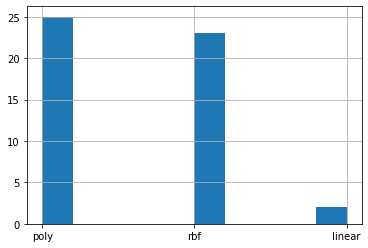

In [6]:
df.sort_values('mean_test_score', ascending=False).head(50)['param_kernel'].hist()

### 平均Accuracy

In [7]:
print('Training data: %1.3f' % np.mean(acc_trn_list))
print('Test data: %1.3f' % np.mean(acc_tst_list))

Training data: 0.987
Test data: 0.974


実験結果より
rbfカーネルを使うと精度が良くなりそうだと予想ができる．　  
この時に使うべきハイパーパラメータとしてはC = 1 or 10, gamma = 0.01 or 0.02 が妥当そうであるとわかる．  
また上のヒストグラムは性能上位50個の分類器にどのカーネルが用いられてるかを表したものであるが，線形カーネルに比べて多項式，rbfカーネルの方がこのデータに対しては性能が高くなりそうだという予想がたつ．

# 課題6-2

In [8]:
# 目的関数の定義
def objective(X,y,trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    
    if kernel == 'linear':
        params = {
            'kernel' : 'linear',
            'C' : trial.suggest_loguniform('C', 1e-5, 1e5)
        }
        clf = SVC(**params)
    
    elif kernel == 'rbf':
        params = {
            'kernel' : 'rbf',
            'C' : trial.suggest_loguniform('C', 1e-5, 1e5),
            'gamma' : trial.suggest_uniform('gamma', 0, 100)
        }
        clf = SVC(**params)
    
    else:
        params = {
            'kernel' : 'poly',
            'C' : trial.suggest_loguniform('C', 1e-5, 1e5),
            'gamma' : trial.suggest_uniform('gamma', 0, 100),
            'degree' : trial.suggest_int('degree', 1,5)
        }
        clf = SVC(**params)
                   
    #内側の交差検証，　上の例とあわせて3foldとする
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    scores = cross_validate(clf, X=X, y=y, cv=kfold)
    return scores['test_score'].mean()
    

In [9]:
optuna.logging.disable_default_handler()
# 外側ループのための交差検証用データ生成インスタンス
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

acc_trn_list = []  #外側ループのfold毎の学習データに対するaccuracy格納用
acc_tst_list = []  #外側ループのfold毎のテストデータに対するaccuracy格納用


k=0
# 内側ループのグリッドサーチ
for train_itr, test_itr in kfold.split(X, y):
    X_train,y_train = X[train_itr],y[train_itr]
    f = partial(objective, X_train, y_train)
    study = optuna.create_study(direction = 'maximize')
    study.optimize(f, n_trials = 500)
    print('Fold #{:2d}; Best Parameter: {} , Best Accuracy: {:.3}'.format(k+1,study.best_params, study.best_value))
    model = SVC(**study.best_params)
    #学習されたハイパーパラメータで訓練，テスト誤差を評価
    model.fit(X_train, y_train)
    acc_trn_list.append(accuracy_score(model.predict(X_train), y_train))
    acc_tst_list.append(accuracy_score(model.predict(X[test_itr]), y[test_itr]))
    k=k+1

Fold # 1; Best Parameter: {'kernel': 'linear', 'C': 0.6615943685866796} , Best Accuracy: 0.982
Fold # 2; Best Parameter: {'kernel': 'linear', 'C': 0.016940280600386663} , Best Accuracy: 0.975
Fold # 3; Best Parameter: {'kernel': 'linear', 'C': 0.046337115711338375} , Best Accuracy: 0.975
Fold # 4; Best Parameter: {'kernel': 'linear', 'C': 0.08411176016820456} , Best Accuracy: 0.975
Fold # 5; Best Parameter: {'kernel': 'linear', 'C': 0.032242224301580726} , Best Accuracy: 0.979
Fold # 6; Best Parameter: {'kernel': 'linear', 'C': 0.020135601813066114} , Best Accuracy: 0.969
Fold # 7; Best Parameter: {'kernel': 'linear', 'C': 0.225456377888212} , Best Accuracy: 0.984
Fold # 8; Best Parameter: {'kernel': 'linear', 'C': 0.10294860500390002} , Best Accuracy: 0.982
Fold # 9; Best Parameter: {'kernel': 'linear', 'C': 0.05015630794106775} , Best Accuracy: 0.971
Fold #10; Best Parameter: {'kernel': 'linear', 'C': 0.10925289254071148} , Best Accuracy: 0.981


## 平均Accuracy

In [10]:
print('Training data: %1.3f' % np.mean(acc_trn_list))
print('Test data: %1.3f' % np.mean(acc_tst_list))

Training data: 0.983
Test data: 0.967


optunaを使った際のテストデータに対する平均Accuracyは96.8%となっており，これはグリッドサーチで求めた際の平均Accuracy97.4%よりも僅かに低くなっている．  
これはoptunaで探索する際に，ハイパーパラメータの探索空間が広すぎたために500回の試行では十分に良い解を見つけられなかったことが考えられる．
一方で，上のBest Parameterを見てわかる通り，optunaを用いたハイパーパラメータ最適化においては線形カーネルつまり，ナイーブなSVMでも十分に良いパフォーマンスを示すことがわかった．  
線形カーネルが選ばれた際のハイパーパラメータについて見ていくと， Cの値が1以下つまり，より正則化項を強めた方が良い結果が出る傾向にあることがわかる．  
グリッドサーチの際はCの下限を1と決め打ってしまっていたが故にこのような結果が得られなかったが，ベイズ最適化をベースとしたoptunaではこのようによしなにハイパーパラメータの値を探索してくれることがこの実験からもわかる．  
また連続変数の場合はグリッドサーチではある程度範囲を限定して整数値変数として探索せざるを得ないが，ベイズ最適化では連続変数も離散変数へと変換することなく最適化を実行することができる．  

上の結果より，適切に正則化項のパラメータを定めれば，ナイーブな線形SVMによって訓練性能が98%近くの高精度の予測性能を叩き出すことができることが確認された．  
つまり，データの特徴としてはほぼほぼ線形分離可能なデータであることがわかった．  
今回のデータは30次元と特徴量次元が大きかったためにカーネル法を使って特徴量を高次元に変換することなく，線形分離できたが，一般に特徴量次元が少なく，非線形変換が必要なような以下のようなデータセットにおいてはカーネルトリックを用いたSVMが有効に機能すると予想される

![FIGURE](fig.png "サンプル")

以下では線形カーネルをなくして上の実験でのグリッドサーチの結果を上回るのかについて検証する

In [11]:
# 目的関数の定義
def objective(X,y,trial):
    kernel = trial.suggest_categorical('kernel', ['rbf'])
    

    if kernel == 'rbf':
        params = {
            'kernel' : 'rbf',
            'C' : trial.suggest_loguniform('C', 1e-5, 1e5),
            'gamma' : trial.suggest_uniform('gamma', 0.01, 5)
        }
        clf = SVC(**params)    
                   
    #内側の交差検証，　上の例とあわせて3foldとする
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    scores = cross_validate(clf, X=X, y=y, cv=kfold)
    return scores['test_score'].mean()
    

optuna.logging.disable_default_handler()
# 外側ループのための交差検証用データ生成インスタンス
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

acc_trn_list = []  #外側ループのfold毎の学習データに対するaccuracy格納用
acc_tst_list = []  #外側ループのfold毎のテストデータに対するaccuracy格納用


k=0
# 内側ループのグリッドサーチ
for train_itr, test_itr in kfold.split(X, y):
    X_train,y_train = X[train_itr],y[train_itr]
    f = partial(objective, X_train, y_train)
    study = optuna.create_study(direction = 'maximize')
    study.optimize(f, n_trials = 500)
    print('Fold #{:2d}; Best Parameter: {} , Best Accuracy: {:.3}'.format(k+1,study.best_params, study.best_value))
    model = SVC(**study.best_params)
    #学習されたハイパーパラメータで訓練，テスト誤差を評価
    model.fit(X_train, y_train)
    acc_trn_list.append(accuracy_score(model.predict(X_train), y_train))
    acc_tst_list.append(accuracy_score(model.predict(X[test_itr]), y[test_itr]))
    k=k+1

Fold # 1; Best Parameter: {'kernel': 'rbf', 'C': 7.791430787452349, 'gamma': 0.023639292969199206} , Best Accuracy: 0.975
Fold # 2; Best Parameter: {'kernel': 'rbf', 'C': 5.469991397043256, 'gamma': 0.019257220562195462} , Best Accuracy: 0.977
Fold # 3; Best Parameter: {'kernel': 'rbf', 'C': 3.8156547170875923, 'gamma': 0.010471886593613188} , Best Accuracy: 0.979
Fold # 4; Best Parameter: {'kernel': 'rbf', 'C': 24.060719386915718, 'gamma': 0.013174275770768665} , Best Accuracy: 0.977
Fold # 5; Best Parameter: {'kernel': 'rbf', 'C': 1.2627504817105897, 'gamma': 0.02138166469252505} , Best Accuracy: 0.975
Fold # 6; Best Parameter: {'kernel': 'rbf', 'C': 2.616778125763535, 'gamma': 0.010601702936296715} , Best Accuracy: 0.973
Fold # 7; Best Parameter: {'kernel': 'rbf', 'C': 20.100625583469448, 'gamma': 0.012606034370855551} , Best Accuracy: 0.984
Fold # 8; Best Parameter: {'kernel': 'rbf', 'C': 2.5609524882293453, 'gamma': 0.014561786062017652} , Best Accuracy: 0.986
Fold # 9; Best Param

In [12]:
print('Training data: %1.3f' % np.mean(acc_trn_list))
print('Test data: %1.3f' % np.mean(acc_tst_list))

Training data: 0.989
Test data: 0.981


optunaでの最適化により，上でのグリッドサーチよりも最終的に良い性能を出すパラメータを求めることができた．  
一方で，optunaでパラメータを探索するにしてもuniformかloguniformにするかなどの選択が依然としてハイパーパラメータとなっているため，かなり職人技が要求されると感じた...

## 追加考察

上では今回用いたデータセットが線形分離できるような比較的簡単なデータと予想したが，その予想を確かめるためにlogistic回帰による分類を試みる

上での実験と同様にlogistic回帰を行うにあたってのハイパーパラメータ探索をoptunaを用いて実行する

In [13]:
from sklearn.linear_model import LogisticRegression
# 目的関数の定義
def objective(X,y,trial):
    
    penalty = trial.suggest_categorical('penalty', ['l2','l1','elasticnet'])
    
    if penalty == 'l1':
        params = {
            'penalty' : 'l1',
            'solver' : trial.suggest_categorical('solver' , ['saga'])
        }
        params['C'] = trial.suggest_loguniform('C', 1e-10, 1e10)
        clf = LogisticRegression(**params)        
    
    elif penalty == 'elasticnet':
        params = {
            'penalty' : 'elasticnet',
            'solver' : trial.suggest_categorical('solver' , ['saga']),
            'l1_ratio' : trial.suggest_uniform('l1_ratio', 0, 1)
        }        
        params['C'] = trial.suggest_loguniform('C', 1e-10, 1e10)
        clf = LogisticRegression(**params)
    else :
        params = {
            'penalty' : 'l2',
            'C' : trial.suggest_loguniform('C', 1e-10, 1e10)
        }
        clf = LogisticRegression(**params)
        
       
    #内側の交差検証，　上の例とあわせて3foldとする
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    scores = cross_validate(clf, X=X, y=y, cv=kfold)
    return scores['test_score'].mean()

In [14]:
optuna.logging.disable_default_handler()
import warnings
warnings.simplefilter('ignore')
# 外側ループのための交差検証用データ生成インスタンス
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

acc_trn_list = []  #外側ループのfold毎の学習データに対するaccuracy格納用
acc_tst_list = []  #外側ループのfold毎のテストデータに対するaccuracy格納用


k=0
# 内側ループのグリッドサーチ
for train_itr, test_itr in kfold.split(X, y):
    X_train,y_train = X[train_itr],y[train_itr]
    f = partial(objective, X_train, y_train)
    study = optuna.create_study(direction = 'maximize')
    study.optimize(f, n_trials = 500)
    print('Fold #{:2d}; Best Parameter: {} , Best Accuracy: {:.3}'.format(k+1,study.best_params, study.best_value))
    model = LogisticRegression(**study.best_params)
    #学習されたハイパーパラメータで訓練，テスト誤差を評価
    model.fit(X_train, y_train)
    acc_trn_list.append(accuracy_score(model.predict(X_train), y_train))
    acc_tst_list.append(accuracy_score(model.predict(X[test_itr]), y[test_itr]))
    k=k+1

Fold # 1; Best Parameter: {'penalty': 'l2', 'C': 0.3671012160319369} , Best Accuracy: 0.982
Fold # 2; Best Parameter: {'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.3786603354745324, 'C': 0.11383307398247758} , Best Accuracy: 0.977
Fold # 3; Best Parameter: {'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.6925857904850952, 'C': 0.7468739249916825} , Best Accuracy: 0.98
Fold # 4; Best Parameter: {'penalty': 'l1', 'solver': 'saga', 'C': 2.7099612805428324} , Best Accuracy: 0.979
Fold # 5; Best Parameter: {'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.7062733462351362, 'C': 0.8587812554472557} , Best Accuracy: 0.982
Fold # 6; Best Parameter: {'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.6805315122814097, 'C': 0.3005484235815352} , Best Accuracy: 0.975
Fold # 7; Best Parameter: {'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.3412363476118888, 'C': 3.5438927099236173} , Best Accuracy: 0.982
Fold # 8; Best Parameter: {'penalty': 'l2', 'C':

## 平均Accuracy

In [15]:
print('Training data: %1.3f' % np.mean(acc_trn_list))
print('Test data: %1.3f' % np.mean(acc_tst_list))

Training data: 0.987
Test data: 0.975


結果として上でのSVM(rbf+optunaを除く)よりも良い性能が得られた．  
従って今回用いたデータについては線形モデルでも十分高性能を出せるような比較的非線形性の強くないデータであることが確認できた．  
CVの結果から，l2正則化項かl1正則化項どちらを選べば良いのかは難しい問題ではあるが，どちらも満遍なく選択されているのでFold6の結果にあるようにelastic net で配合率を50%にしておけばある程度のデータのばらつきがあったとしても良い性能を出すことが予想できる．